##Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cd /content/drive/My\ Drive/Thesis/Notebooks
%cd /content/drive/My\ Drive/Thesis/Notebooks
!ls

/content/drive/.shortcut-targets-by-id/12hFNvKrLb6ISrBovPsJBuxTMReojZZrS/Thesis/Notebooks
Classifier-Gene-2.ipynb    Modified_MultiSurf.ipynb
Classifier-Gene.ipynb	   Modified_Overlapping_MultiSurf.ipynb
Classifier.ipynb	   MultiSurf.ipynb
Classifier-Normal-2.ipynb  Ovelapping_ReliefF.ipynb
Classifier-Normal.ipynb    Overlapping_MultiSurf.ipynb
IRelief2.ipynb		   ReliefF.ipynb
IRelief.ipynb		   Relief.ipynb
Iterative_MultiSurf.ipynb  RFS.ipynb
Load_dataset.ipynb


##Installing Libraries

In [ ]:
!pip install ipynb
!pip install skrebate

  Created wheel for skrebate: filename=skrebate-0.61-cp36-none-any.whl size=29257 sha256=171d854443a8e2e5200932b4bf9aa0f3467ad4306d0e1adf92995887b09a3444
  Stored in directory: /root/.cache/pip/wheels/ae/d8/ae/9b51d487e9d02219996d6c260255a216ef07d905b0a0b00ce3
Successfully built skrebate


##Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF, MultiSURF, SURF, SURFstar, MultiSURFstar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from ipynb.fs.full.Load_dataset import load_dataset, get_dataset_names, load_gene_dataset, get_gene_dataset_names
from ipynb.fs.full.ReliefF import ReliefF_configure
from ipynb.fs.full.MultiSurf import MultiSurf_configure
from ipynb.fs.full.Modified_MultiSurf import Modified_MultiSurf_configure
from ipynb.fs.full.Iterative_MultiSurf import Iterative_MultiSurf_configure
from ipynb.fs.full.RFS import RFS_configure
from ipynb.fs.full.Relief import Relief_configure
from ipynb.fs.full.IRelief import I_Relief_configure
from ipynb.fs.full.IRelief2 import I_Relief2_configure
from ipynb.fs.full.Overlapping_MultiSurf import Overlapping_MultiSurf_configure
from ipynb.fs.full.Modified_Overlapping_MultiSurf import Modified_Overlapping_MultiSurf_configure
from ipynb.fs.full.Ovelapping_ReliefF import Ovelapping_ReliefF_configure

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1
ranked
[0 2 6 1 3 4 5]
weight
[0.46217002 0.29966507 0.46217002 0.29966507 0.29966507 0.29966507
 0.46217002]
(200, 20) (200,)
ranked
[12  1  8 11  6  3  5  0  7 13  9 10  2  4 14 16 15 19 18 17]
weight
[0.22309303 0.23140817 0.22180524 0.22498413 0.22167134 0.22399428
 0.22647824 0.22303407 0.22969932 0.22230667 0.22206899 0.22667603
 0.23257596 0.22233638 0.22164494 0.22002054 0.22068688 0.21885242
 0.21901366 0.21911369]
1.0000000014036095
(100, 15) (100,)
ranked
[ 7  6  3  0  1  2  4  8  5  9 13 11 12 14 10]
weight
[ 0.03105736  0.03037178  0.02167202  0.04760437  0.0154457   0.01292966
  0.05815072  0.0827284   0.01507508  0.00673921 -0.02146872 -0.00360202
 -0.00383216  0.00128816 -0.00475547]


In [ ]:
path = '/content/drive/My Drive/Thesis/Results'
randomState = 123

## Load Dataset

In [ ]:
def dataset_preparetion(iterationNum, dName, dataset_dict, noisePercentage = 0, datasetType= 'normal'):
  print('datasetType= ',datasetType)
  X = dataset_dict['attributes']
  Y = dataset_dict['target']
  categoricalX = dataset_dict['categoricalX']
  trainSize = dataset_dict['trainSize']
  testSize = dataset_dict['testSize']
  # print("Before : ", X.shape, Y.shape)

  # Adding irrelavant Features
  mu, sigma = 0, 5 # mean and standard deviation
  np.random.seed(randomState)
  irrelevantFeatures = np.random.normal(mu, sigma, (X.shape[0], 50))
  X = np.concatenate((X, irrelevantFeatures), axis=1)
  # print("After : ", X.shape, Y.shape)  
  
  XTrain, XTest, YTrain, YTest = train_test_split(X, Y, train_size = trainSize, test_size= testSize, stratify=Y, random_state = randomState + iterationNum)

  # Adding noise i.e. misslabeling training data
  if noisePercentage > 0:
    classes = np.unique(YTrain)

    numOfMislabels = np.floor(len(YTrain) * (noisePercentage/100)).astype(int)
    # print(numOfMislabels)

    # Choose the random instances
    rndIdx = np.random.choice(len(YTrain), numOfMislabels, replace=False)   # random indices of m instances from total of n instances
    # print(rndIdx)

    for idx in rndIdx:
      restOfTheClasses = classes[classes != YTrain[idx]]
      YTrain[idx] = restOfTheClasses[np.random.choice(len(restOfTheClasses), 1, replace=False).item()]
      # print("before : ", Y[idx])
      # print('after : ', newLabel) 

  return XTrain, XTest, YTrain, YTest, categoricalX

##Preprocessing and Feature Selection

In [ ]:
def feature_selection(X, Y, K_RFS = 7, K_ReliefF = 10, theta_RFS = 3, numUpdates='all', numOfIterations= 5, prior='uniform', categoricalX='off', kernelWidth = 3, theta_IRelief = 1e-9): 
  cache = {}
  #cache['RFS'] = RFS_configure(X,Y, K = K_RFS, theta= theta_RFS)
  
  isBinary = len(np.unique(Y)) == 2
  # if isBinary:
  #    cache['Relief'] = Relief_configure(X,Y, numUpdates=numUpdates, categoricalX=categoricalX)
  
  cache['ReliefF'] = ReliefF_configure(X, Y, K=K_ReliefF, prior=prior, numUpdates=numUpdates, categoricalX=categoricalX) 
  # cache['IRelief'] = I_Relief_configure(X, Y, numOfIterations=numOfIterations, categoricalX = categoricalX, kernelWidth = kernelWidth, theta = theta_IRelief, prior=prior)
  #cache['IRelief2'] = I_Relief2_configure(X, Y, numOfIterations=numOfIterations, categoricalX = categoricalX, kernelWidth = kernelWidth, theta = theta_IRelief)
  # cache['MultiSurf'] = MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX)
  # cache['Modified_MultiSurf'] = Modified_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX)
  # cache['Iterative_MultiSurf'] = Iterative_MultiSurf_configure(X,Y,prior=prior, numOfIterations = numOfIterations, numUpdates=numUpdates, categoricalX=categoricalX, theta = theta_IRelief)
  # cache['Overlapping_MultiSurf'] = Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = kernelWidth)
  # cache['Modified_Overlapping_MultiSurf'] = Modified_Overlapping_MultiSurf_configure(X,Y,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth = kernelWidth)
  cache['Overlapping_ReliefF'] = Ovelapping_ReliefF_configure(X,Y,K=K_ReliefF,prior=prior, numUpdates=numUpdates, categoricalX=categoricalX, kernelWidth=kernelWidth)

  # From ReBATE Framework - ReliefF
  # reliefF = ReliefF(n_features_to_select=min(X.shape[1]-50, 50), n_neighbors=K_ReliefF)
  # reliefF.fit(X, Y)
  # weight = reliefF.feature_importances_
  # ranked = reliefF.top_features_
  # cache['ReBATE_ReliefF'] = ranked, weight

  # From ReBATE Framework - MultiSurf
  multiSurf = MultiSURF(n_features_to_select=min(X.shape[1], 1000))
  multiSurf.fit(X, Y)
  weight = multiSurf.feature_importances_
  ranked = multiSurf.top_features_
  cache['ReBATE_MultiSURF'] = ranked, weight

  return cache

In [ ]:
# print('ranked')
# print(ranked)
# print('Rvalue')
# print(Rvalue[np.array(ranked, dtype=int)])

In [ ]:
# print('ranked')
# print(reliefF_ranked)
# print('reliefF_weight')
# print(reliefF_weight[np.array(reliefF_ranked, dtype=int)])

##Feature Scaling

In [ ]:
def feature_scaling(XTrain, XTest):
  scaler = StandardScaler()
  scaler.fit(XTrain)
  # print("Mean :",scaler.mean_, "Var :", scaler.var_)

  XTrain = scaler.transform(XTrain)
  XTest = scaler.transform(XTest)

  return XTrain, XTest, scaler

##KNN classification

In [ ]:
def KNN_classifier(XTrain, YTrain, XTest, YTest, Num_neighbors=7):
  classifier = KNeighborsClassifier(n_neighbors=Num_neighbors)
  classifier.fit(XTrain, YTrain)  
  Y_pred = classifier.predict(XTest)
  score = accuracy_score(YTest, Y_pred)
  # score1 = classifier.score(XTest, YTest)
  # print(score,score1)
  
  return Y_pred, score

##SVM classification

In [ ]:
def SVM_classifier(XTrain, YTrain, XTest, YTest, kernel='linear', degree=3):
  # degree is for polynomial kernel
  svclassifier = SVC(kernel=kernel)
  svclassifier.fit(XTrain, YTrain)
  Y_pred = svclassifier.predict(XTest)
  score = accuracy_score(YTest, Y_pred)

  return Y_pred, score

##Evaluataion

In [ ]:
def evaluation(YTest, Y_pred):
  print(confusion_matrix(YTest, Y_pred))
  print(classification_report(YTest, Y_pred))

##Classification

In [ ]:
def classification(XTrain, XTest, YTrain, YTest, ranked, algo, featureRange, datasetName, Num_neighbors=7, kernel='linear', degree=3):

  scoreCollection = np.array([])
  YPredCollection = []
  XTrain, XTest, _ = feature_scaling(XTrain, XTest)

  for n in featureRange:
    feature_idx = np.array(ranked[0:n])
    
    # if np.sum(feature_idx>=XTrain.shape[1]-50):
    #   print('irrelevent selected: ',feature_idx)
    # print(feature_idx)
    
    # print(feature_idx)
    scores = np.array([])
    XSubTrain, XSubTest = XTrain[:, feature_idx], XTest[:, feature_idx]
    
    # print("XSubTRAIN:", XSubTrain.shape, "XSubTEST:", XSubTest.shape)
    # print("YTRAIN:", YTrain.shape, "YTEST:", YTest.shape)

    if algo == 'KNN':
      YPred, score = KNN_classifier(XSubTrain, YTrain, XSubTest, YTest,  Num_neighbors=Num_neighbors)
    else:
      YPred, score = SVM_classifier(XSubTrain, YTrain, XSubTest, YTest, kernel=kernel, degree=degree)

    scoreCollection = np.append(scoreCollection, score)
    YPredCollection.append(YPred)

  # print(datasetName, scoreCollection)
  return np.array(YPredCollection), scoreCollection

## Run and Save results

In [ ]:
def performanceFileWrite(metricName, arrayCollection, index, featureRange, dName, classifierName, isNoisy ):
  df = pd.DataFrame(arrayCollection, index=index, columns=featureRange)
  df = df.rename_axis('#features', axis='columns')
  print("{} for the dataset {} and classifier {} (Noisy = {})".format(metricName ,dName, classifierName, isNoisy))
  print(df)
  if isNoisy:
    df.to_csv('/content/drive/My Drive/Thesis/Results/Gene/Performance/{}/{}_{}_withNoise.csv'.format(metricName, dName, classifierName), sep=",")
  else:
    df.to_csv('/content/drive/My Drive/Thesis/Results/Gene/Performance/{}/{}_{}_withoutNoise.csv'.format(metricName, dName, classifierName), sep=",")

In [ ]:
def performanceReport(methods, YActual, YPredDict, featureRange, dName, isNoisy, classifierName):
  
  truePosPlusSupportArrayCollection = []
  # precisionArrayCollection, recallArrayCollection, f1scoreArrayCollection = [], [], []
  for method in methods: 
    truePosPlusSupportDict = {}
    # precisionDict, recallDict, f1scoreDict = {}, {}, {}
    for YPred in YPredDict[method]:
      confMat = confusion_matrix(YActual, YPred)
      # precision, recall, f1score, _ = precision_recall_fscore_support(YActual, YPred, average=None)
      truePositives = np.diag(confMat) 
      support = np.sum(confMat, axis = 1) 
      for i in range(len(truePositives)):
        if i not in truePosPlusSupportDict:
          truePosPlusSupportDict[i] = np.array(['A={},TP={}'.format(support[i], truePositives[i])])
          # precisionDict[i] = np.array(precision[i])
          # recallDict[i] = np.array(recall[i])
          # f1scoreDict[i] = np.array(f1score[i])
        else:
          truePosPlusSupportDict[i] = np.append(truePosPlusSupportDict[i], 'A={},TP={}'.format(support[i], truePositives[i]))
          # precisionDict[i] = np.append(precisionDict[i], precision[i])
          # recallDict[i] = np.append(recallDict[i], recall[i])
          # f1scoreDict[i] = np.append(f1scoreDict[i], f1score[i])

    truePosPlusSupportArray = []
    # precisionArray, recallArray, f1scoreArray = [], [], []
    for key in truePosPlusSupportDict:
      truePosPlusSupportArray.append(truePosPlusSupportDict[key])
      # precisionArray.append(precisionDict[key])
      # recallArray.append(recallDict[key])
      # f1scoreArray.append(f1scoreDict[key])
    truePosPlusSupportArrayCollection = truePosPlusSupportArrayCollection + truePosPlusSupportArray
    # precisionArrayCollection = precisionArrayCollection + precisionArray
    # recallArrayCollection = recallArrayCollection + recallArray
    # f1scoreArrayCollection = f1scoreArrayCollection + f1scoreArray

  truePosPlusSupportArrayCollection = np.array(truePosPlusSupportArrayCollection)
  # precisionArrayCollection = np.array(precisionArrayCollection)
  # recallArrayCollection = np.array(recallArrayCollection)
  # f1scoreArrayCollection = np.array(f1scoreArrayCollection)
  
  classes = np.unique(YActual)
  # Confusion matrix
  index = pd.MultiIndex.from_product([methods, classes], names=['Method', 'Classes'])

  performanceFileWrite('ConfusionMatrix', truePosPlusSupportArrayCollection, index, featureRange, dName, classifierName, isNoisy )
  # performanceFileWrite('Precision', precisionArrayCollection, index, featureRange, dName, classifierName, isNoisy )
  # performanceFileWrite('Recall', recallArrayCollection, index, featureRange, dName, classifierName, isNoisy )
  # performanceFileWrite('F1score', f1scoreArrayCollection, index, featureRange, dName, classifierName, isNoisy )

In [ ]:
def run_and_save_output(dName, datasetType='gene', noisePercentage=0, numOfPoints = 40):
  # print('in run_and_save_output datasetType= ',datasetType)
  isNoisy = noisePercentage > 0

  totalSvmScores = 0
  totalKnnScores = 0

  dataset_dict =   load_dataset(dName) if (datasetType == 'normal') else load_gene_dataset(dName) 
  # print('datasetType= ',datasetType)

  X = dataset_dict['attributes']
  Y = dataset_dict['target']
  categoricalX = dataset_dict['categoricalX'] 
  
  # leaveOneOut = LeaveOneOut()
  # numOfsplits = leaveOneOut.get_n_splits(X)

  kFold = KFold(n_splits=10)
  numOfsplits = kFold.get_n_splits(X)
  YActual = np.array([])
  YPredSVMDict = {}
  YPredKNNDict = {}

  for trainIndex, testIndex in kFold.split(X):
    # print("TRAIN:", trainIndex, "TEST:", testIndex)
    XTrain, XTest, YTrain, YTest = X[trainIndex], X[testIndex], Y[trainIndex], Y[testIndex]
    YActual = np.append(YActual, YTest)
    # # Adding noise i.e. misslabeling training data
    # if noisePercentage > 0:
    #   classes = np.unique(YTrain)

    #   numOfMislabels = np.floor(len(YTrain) * (noisePercentage/100)).astype(int)
    #   # print(numOfMislabels)

    #   # Choose the random instances
    #   rndIdx = np.random.choice(len(YTrain), numOfMislabels, replace=False)   # random indices of m instances from total of n instances
    #   # print(rndIdx)

    #   for idx in rndIdx:
    #     restOfTheClasses = classes[classes != YTrain[idx]]
    #     YTrain[idx] = restOfTheClasses[np.random.choice(len(restOfTheClasses), 1, replace=False).item()]
    #     # print("before : ", Y[idx])
    #     # print('after : ', newLabel) 

    # Here if we estimate best K for KNN classification using 10 fold stratified cross validation, it will help us to do comparison more fairly.
    # Here If we estimate best kernelWidth sigma for I-Relief using 10 fold stratified cross validation, it will help us to do comparison more fairly. 
    # Here If we estimate best K(i.e. number of nearest hits and misses) for Relief-F using 10 fold stratified cross validation, it will help us to do comparison more fairly. 


    # performing feture selection 
    # Using kernelwidth sigma = 3 and number of iterations = 20 and convergence_threshold = 1e-5 for I-Relief-1 and I-Relief-2
    # Using number of nearest hits and misses i.e. K = 10 for ReliefF and also using all the training data for Relief and ReliefF
    # Using number of nearest Neighbours k = 7 and overlapping_threshold = 3 for RFS
    # print('Training data size: training examples = {}, features= {}'.format(XTrain.shape[0], XTrain.shape[1]))
    cache = feature_selection(XTrain, YTrain, K_RFS = 7, K_ReliefF = 10, theta_RFS = 3, numUpdates='all', numOfIterations = 20, prior='empirical', categoricalX='off', kernelWidth = 3, theta_IRelief = 1e-5)
    featureRange = np.unique(np.linspace(1, min(XTrain.shape[1], 2000), numOfPoints, dtype=int))
    
    svmScores = []
    knnScores = []
    methods = np.array([])

    for method, rankWeight in cache.items():
      ranked, weight = rankWeight
      # print(method, ranked[:min(XTrain.shape[1], 1000)])
      methods = np.append(methods, method)

      svmYPred, svmScore = classification(XTrain, XTest, YTrain, YTest, ranked, algo = 'SVM', featureRange = featureRange, datasetName = dName, kernel='linear', degree=3)
      knnYPred, knnScore = classification(XTrain, XTest, YTrain, YTest, ranked, algo = 'KNN', featureRange = featureRange, datasetName = dName, Num_neighbors=7)
      svmScores.append(svmScore)
      knnScores.append(knnScore)

      if method not in YPredSVMDict:
        YPredSVMDict[method] = svmYPred
        YPredKNNDict[method] = knnYPred
      else:
        YPredSVMDict[method] = np.append(YPredSVMDict[method], svmYPred, axis = 1)
        YPredKNNDict[method] = np.append(YPredKNNDict[method], knnYPred, axis = 1)

    svmScores = np.array(svmScores)
    knnScores = np.array(knnScores)
    totalSvmScores = totalSvmScores + svmScores
    totalKnnScores = totalKnnScores + knnScores

  avgSvmScores = totalSvmScores/numOfsplits
  avgKnnScores = totalKnnScores/numOfsplits

  classifiers = np.array(['KNN', 'SVM'])
  # print(classifiers.shape, methods.shape)
  # print(svmScores.shape, knnScores.shape)
  index = pd.MultiIndex.from_product([classifiers, methods], names=['Classifier', 'Method'])
  df = pd.DataFrame(np.concatenate((avgKnnScores, avgSvmScores), axis=0), index=index, columns=featureRange)
  df = df.rename_axis('#features', axis='columns')
  print("Dataset Name :", dName)
  print(df)
  if isNoisy:
    df.to_csv('/content/drive/My Drive/Thesis/Results/Gene/ClassificationAccuracy/{}_withNoise.csv'.format(dName), sep=",")
  else:
    df.to_csv('/content/drive/My Drive/Thesis/Results/Gene/ClassificationAccuracy/{}_withoutNoise.csv'.format(dName), sep=",")

  # Writing precision, recall, f1-score, support to the file
  performanceReport(methods, YActual, YPredSVMDict, featureRange, dName, isNoisy, 'SVM')
  performanceReport(methods, YActual, YPredKNNDict, featureRange, dName, isNoisy, 'KNN')

##Plotting

In [ ]:
def plotting(dName):

  plotStyles = {
      'markers' : ["o","^","*","s","P","X","d"],
      'color' : ['#00cec9', '#6c5ce7', '#d63031', '#273c75', '#00b894', '#0984e3', '#74b9ff'],
      'lineStyle' : 'solid',
      'markerSize' :  5,
  }

  
  # extension = ['withoutNoise', 'withNoise']
  extension = ['withoutNoise']
  plt.figure(figsize=(20,10*len(extension)))
  
  for i in range(len(extension)):
    df = pd.read_csv('/content/drive/My Drive/Thesis/Results/Gene/ClassificationAccuracy/{}_{}.csv'.format(dName, extension[i]), sep=",", index_col=['Classifier','Method'])
    noOfFeatures = np.array(df.columns, dtype=int)
    classifiers = np.unique(df.index.get_level_values('Classifier'))
    noOfClassifiers = len(classifiers)
    methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)
    lines = []

    for j in range(noOfClassifiers):
      plt.subplot(len(extension), noOfClassifiers, (noOfClassifiers * (i)) + j + 1).set_title('Dataset: {} {}, Classifier : {} '.format(dName, extension[i], classifiers[j]))
      plt.ylabel('Accuracy')
      plt.xlabel('#features')
      for k in range(noOfMethods):
        line,  = plt.plot(noOfFeatures, df.loc[(classifiers[j], methods[k])], color=plotStyles['color'][k], linestyle=plotStyles['lineStyle'], 
                marker=plotStyles['markers'][k], markersize=plotStyles['markerSize'], label=methods[k])
        lines.append(line)
      plt.legend(lines, methods)
        
  plt.show()


### Colon

dataset: colon
instances = 62, features= 2000 
Dataset Name : colon
#features                           1         52    ...      1948      2000
Classifier Method                                   ...                    
KNN        ReliefF              0.754762  0.835714  ...  0.740476  0.726190
           Overlapping_ReliefF  0.754762  0.835714  ...  0.740476  0.726190
           ReBATE_MultiSURF     0.785714  0.823810  ...  0.740476  0.726190
SVM        ReliefF              0.788095  0.852381  ...  0.883333  0.883333
           Overlapping_ReliefF  0.788095  0.852381  ...  0.883333  0.883333
           ReBATE_MultiSURF     0.785714  0.835714  ...  0.883333  0.883333

[6 rows x 40 columns]
ConfusionMatrix for the dataset colon and classifier SVM (Noisy = False)
#features                          1           52    ...        1948        2000
Method              Classes                          ...                        
ReliefF             1.0      A=40,TP=37  A=40,TP=36  ...  A=40,TP=

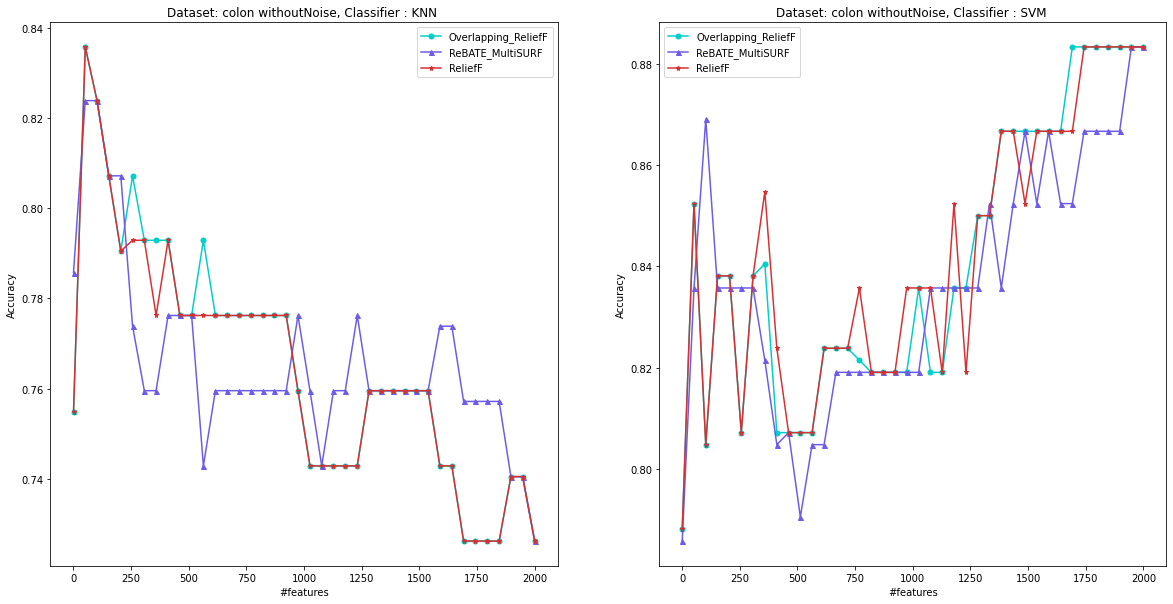

In [ ]:
# run_and_save_output(dName = 'colon', datasetType = 'gene')
# run_and_save_output(dName ='colon', datasetType = 'gene', noisePercentage=10)
plotting('colon')

###lymphoma

dataset: lymphoma
instances = 66, features= 4026 
Dataset Name : lymphoma
#features                           1         52    ...      1948      2000
Classifier Method                                   ...                    
KNN        ReliefF              0.690476  0.816667  ...  0.866667  0.866667
           Overlapping_ReliefF  0.690476  0.800000  ...  0.866667  0.866667
           ReBATE_MultiSURF     0.571429  0.900000  ...  0.866667  0.866667
SVM        ReliefF              0.690476  0.885714  ...  0.950000  0.950000
           Overlapping_ReliefF  0.690476  0.916667  ...  0.950000  0.950000
           ReBATE_MultiSURF     0.614286  0.900000  ...  0.950000  0.950000

[6 rows x 40 columns]
ConfusionMatrix for the dataset lymphoma and classifier SVM (Noisy = False)
#features                          1           52    ...        1948        2000
Method              Classes                          ...                        
ReliefF             1.0      A=46,TP=43  A=46,TP=45  ... 

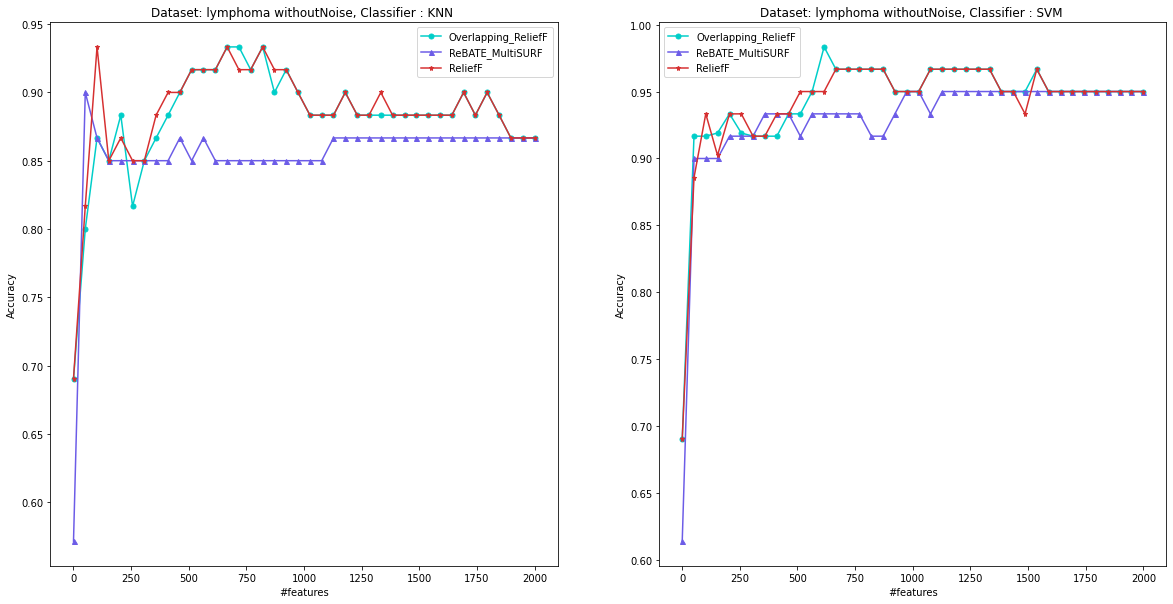

In [ ]:
# run_and_save_output(dName = 'lymphoma', datasetType = 'gene')
# run_and_save_output(dName = 'lymphoma', datasetType = 'gene', noisePercentage=10)
plotting('lymphoma')

###mll

dataset: mll
instances = 72, features= 12582 
Dataset Name : mll
#features                           1         52    ...      1948      2000
Classifier Method                                   ...                    
KNN        ReliefF              0.778571  0.901786  ...  0.805357  0.805357
           Overlapping_ReliefF  0.778571  0.901786  ...  0.791071  0.791071
           ReBATE_MultiSURF     0.607143  0.885714  ...  0.871429  0.871429
SVM        ReliefF              0.707143  0.914286  ...  0.957143  0.957143
           Overlapping_ReliefF  0.707143  0.900000  ...  0.957143  0.957143
           ReBATE_MultiSURF     0.550000  0.900000  ...  0.928571  0.928571

[6 rows x 40 columns]
ConfusionMatrix for the dataset mll and classifier SVM (Noisy = False)
#features                          1           52    ...        1948        2000
Method              Classes                          ...                        
ReliefF             1.0       A=20,TP=2  A=20,TP=18  ...  A=20,TP=19  A

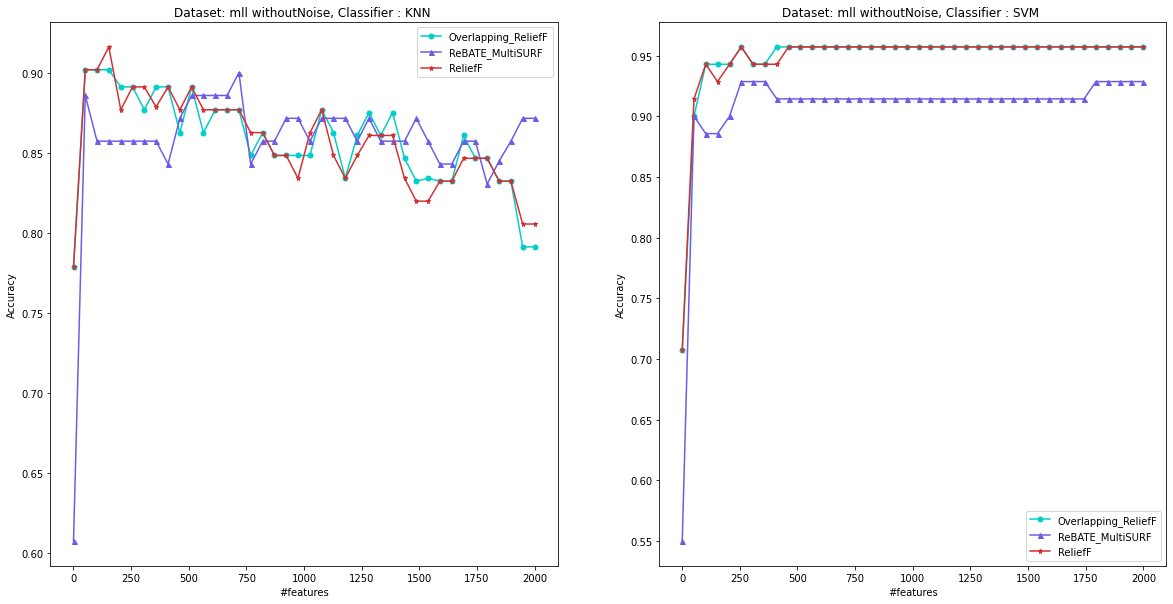

In [ ]:
# run_and_save_output(dName = 'mll', datasetType = 'gene')
# run_and_save_output(dName = 'mll', datasetType = 'gene', noisePercentage=10)
plotting('mll')

###srbct

In [ ]:
run_and_save_output(dName = 'srbct', datasetType = 'gene')
# run_and_save_output(dName = 'srbct', datasetType = 'gene', noisePercentage=10)
plotting('srbct')

NameError: ignored

###Leukemia

In [ ]:
run_and_save_output(dName = 'leukemia', datasetType = 'gene')
# run_and_save_output(dName ='leukemia', datasetType = 'gene', noisePercentage=10)
plotting('leukemia')

NameError: ignored

###Leukemia3c

In [ ]:
run_and_save_output(dName = 'leukemia3c', datasetType = 'gene')
# run_and_save_output(dName ='leukemia3c', datasetType = 'gene', noisePercentage=10)
plotting('leukemia3c')

###Leukemia4c(imbalanced)

In [ ]:
run_and_save_output(dName = 'leukemia4c', datasetType = 'gene')
# run_and_save_output(dName = 'leukemia4c', datasetType = 'gene', noisePercentage=10)
plotting('leukemia4c')

###ovarian

In [ ]:
run_and_save_output(dName = 'ovarian', datasetType = 'gene')
# run_and_save_output(dName = 'ovarian', datasetType = 'gene', noisePercentage=10)
plotting('ovarian')

###lung2(imbalanced)

In [ ]:
run_and_save_output(dName = 'lung2', datasetType = 'gene')
# run_and_save_output(dName = 'lung2', datasetType = 'gene', noisePercentage=10)
plotting('lung2')